### Imports and Setup

In [1]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from utils.models import model_mapping
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import json
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# ====== Pickle Setup ======
# want to test or debug?          -> USE_PICKLE = False
# want to use existing pickle?    -> USE_PICKLE = True, OVERWRITE_PICKLE = False
# want to rerun & overwrite?      -> USE_PICKLE = True, OVERWRITE_PICKLE = True
USE_PICKLE = True
OVERWRITE_PICKLE = True

# configuration
runs = 100  # for testing; switch to 100 for final
np.random.seed(42)
random_seeds = np.random.randint(0, 10000, size=runs)


data_dir = "./data"
results_dir = "./results"
summary_dir = os.path.join(results_dir, "summaries")
pickle_dir = os.path.join(results_dir, "pickles")
os.makedirs(summary_dir, exist_ok=True)
os.makedirs(pickle_dir, exist_ok=True)

# getting dataset names from CSV files
dataset_names = sorted([
    f.replace(".csv", "") for f in os.listdir(data_dir)
    if f.endswith(".csv") and not f.startswith(".")
])

final_results = {}
combined_detail_rows = []

### Training and Evaluation for Each Dataset

In [2]:
for dataset_name in dataset_names:
    print(f"\n{'='*60}\n Running Training Pipeline on: {dataset_name}\n{'='*60}")

    # pickle load/delete logic
    pickle_path = os.path.join(pickle_dir, f"training_output_{dataset_name}.pkl")

    if USE_PICKLE and os.path.exists(pickle_path) and OVERWRITE_PICKLE:
        print(f"Deleting old pickle for {dataset_name} before recomputing...")
        os.remove(pickle_path)

    if USE_PICKLE and os.path.exists(pickle_path) and not OVERWRITE_PICKLE:
        print(f"Found pickle for {dataset_name}, loading instead of recomputing...")
        try:
            with open(pickle_path, "rb") as f:
                loaded = pickle.load(f)
            if loaded.get("version") != "v2":
                raise ValueError(f"Outdated pickle detected for {dataset_name}. Please re-run with OVERWRITE = True.")
            final_results[dataset_name] = {
                "best_model": loaded["best_model"],
                "metrics": loaded["best_model_metrics"]
            }
            combined_detail_rows.append({
                "dataset": dataset_name,
                "model_name": loaded["best_model"],
                **loaded["best_model_metrics"],
                "runs": loaded["runs"],
                "random_seeds": ";".join(map(str, loaded["random_seeds"]))
            })
            continue
        except (pickle.UnpicklingError, EOFError) as e:
            raise ValueError(f"Corrupted pickle detected for {dataset_name}. Delete it or set OVERWRITE = True.") from e
    

    # loading data
    df = pd.read_csv(f"{data_dir}/{dataset_name}.csv", index_col=0)
    X = df.drop(columns=["Diagnosis", "Diagnosis_labeled"])
    y = df["Diagnosis_labeled"]

    # encoding labels
    le = LabelEncoder()
    y = le.fit_transform(y)
    
    # initializing models from mapping
    models = {name: model_class() for name, model_class in model_mapping.items()}
    # dictionary to store model evaluation results
    model_results = {name: np.zeros((runs, 5)) for name in models}
    # will store metrics & per-run outputs for later use
    metadata = {
        "dataset": dataset_name,
        "metrics": {},
        "runs": runs,
        "random_seeds": random_seeds.tolist()
    }

    # training Loop
    for i, seed in enumerate(tqdm(random_seeds, desc=f"    Progress ({dataset_name})")):
        # showing progress
        if (i + 1) % 10 == 0 or i == 0:
            print(f"    Run {i + 1} (seed={seed})")
            
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
        
        # preprocessing
        vt = VarianceThreshold(threshold=0)
        X_train = vt.fit_transform(X_train)
        X_test = vt.transform(X_test)
        
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # training & evaluating each model
        for name, current_model in models.items():
            current_model.train(X_train_scaled, y_train)
            metrics_dict = current_model.predict(X_test_scaled, y_test)
            model_results[name][i, :] = [
                metrics_dict["AUC"],
                metrics_dict["Accuracy"],
                metrics_dict["Precision"],
                metrics_dict["Recall"],
                metrics_dict["F1"]
            ]

            # extracting predictions
            y_prob = metrics_dict.get("y_prob")
            y_pred = metrics_dict.get("y_pred")

            # collecting per-run predictions
            if "models" not in metadata:
                metadata["models"] = {}

            if name not in metadata["models"]:
                metadata["models"][name] = {
                    "run_predictions": [],
                    "avg_metrics": {}
                }

            metadata["models"][name]["run_predictions"].append({
                "run_id": i,
                "seed": int(seed),
                "y_true": y_test.tolist(),
                "y_prob": y_prob.tolist() if isinstance(y_prob, np.ndarray) else (y_prob if isinstance(y_prob, list) else []),
                "y_pred": y_pred.tolist() if isinstance(y_pred, np.ndarray) else (y_pred if isinstance(y_pred, list) else [])
            })
            

    # computing average metrics
    average_results = {
    name: np.mean(results, axis=0) for name, results in model_results.items()
    }

    # converting average metrics into a structured dict per model
    model_avg_metrics = {
        name: {
            "AUC": float(avg[0]),
            "Accuracy": float(avg[1]),
            "Precision": float(avg[2]),
            "Recall": float(avg[3]),
            "F1": float(avg[4])
        }
        for name, avg in average_results.items()
    }

    # best model selection with priority on AUC while using other metrics as tiebreakers
    best_model = max(average_results, key=lambda name: tuple(average_results[name]))
    best_metrics = average_results[best_model]

    print(f"\nBest Model for {dataset_name}: {best_model}")
    print(
        f"AUC: {best_metrics[0]:.5f}\n"
        f"Accuracy: {best_metrics[1]:.5f}\n"
        f"Precision: {best_metrics[2]:.5f}\n"
        f"Recall: {best_metrics[3]:.5f}\n"
        f"F1: {best_metrics[4]:.5f}\n"
    )

    # updating metadata with final metrics
    metadata["model_name"] = best_model
    metadata["metrics"] = {
        "AUC": float(best_metrics[0]),
        "Accuracy": float(best_metrics[1]),
        "Precision": float(best_metrics[2]),
        "Recall": float(best_metrics[3]),
        "F1": float(best_metrics[4])
    }

    # savin per-model average metrics into metadata["models"]
    for name in models:
        if name in metadata["models"]:
            metadata["models"][name]["avg_metrics"] = model_avg_metrics[name]

    # preparing row for consolidated CSV + JSON
    metadata_flat = {
        "dataset": dataset_name,
        "model_name": best_model,
        **metadata["metrics"],
        "runs": runs,
        "random_seeds": ";".join(map(str, random_seeds))
    }
    combined_detail_rows.append(metadata_flat)

    # tracking best model summary
    final_results[dataset_name] = {
        "best_model": best_model,
        "metrics": metadata["metrics"]
    }

    # saving full per-run output
    training_output = {
        "dataset": dataset_name,
        "runs": runs,
        "random_seeds": random_seeds.tolist(),
        "best_model": best_model,
        "best_model_metrics": metadata["metrics"],
        "models": metadata["models"]
    }

    pickle_path = os.path.join(pickle_dir, f"training_output_{dataset_name}.pkl")
    training_output["version"] = "v2"
    if USE_PICKLE:
        with open(pickle_path, "wb") as f:
            pickle.dump(training_output, f)


# saving JSON best model summary
with open(os.path.join(summary_dir, "training_best_models.json"), "w") as f:
    json.dump(final_results, f, indent=2)
print(f"\nResults saved to: {summary_dir}/training_best_models.json")

# saving detailed CSV & JSON with full model config info
details_csv_path = os.path.join(summary_dir, "training_best_model_details.csv")
details_json_path = os.path.join(summary_dir, "training_best_model_details.json")

pd.DataFrame(combined_detail_rows).to_csv(details_csv_path, index=False)
with open(details_json_path, "w") as f:
    json.dump(combined_detail_rows, f, indent=2)

print(f"Saved detailed results to:")
print(f"  - {details_csv_path}")
print(f"  - {details_json_path}")




 Running Training Pipeline on: clr
Deleting old pickle for clr before recomputing...


    Progress (clr):   0%|                               | 0/100 [00:00<?, ?it/s]

    Run 1 (seed=7270)


    Progress (clr):   9%|█▉                   | 9/100 [07:40<1:11:57, 47.44s/it]

    Run 10 (seed=8322)


    Progress (clr):  19%|███▊                | 19/100 [16:04<1:06:03, 48.93s/it]

    Run 20 (seed=3385)


    Progress (clr):  29%|██████▍               | 29/100 [24:15<58:21, 49.32s/it]

    Run 30 (seed=189)


    Progress (clr):  39%|████████▌             | 39/100 [32:35<52:03, 51.20s/it]

    Run 40 (seed=8838)


    Progress (clr):  49%|██████████▊           | 49/100 [41:00<41:29, 48.81s/it]

    Run 50 (seed=7099)


    Progress (clr):  59%|████████████▉         | 59/100 [49:18<35:09, 51.45s/it]

    Run 60 (seed=3843)


    Progress (clr):  69%|███████████████▏      | 69/100 [57:40<26:52, 52.01s/it]

    Run 70 (seed=1016)


    Progress (clr):  79%|███████████████▊    | 79/100 [1:05:07<15:36, 44.61s/it]

    Run 80 (seed=4859)


    Progress (clr):  89%|█████████████████▊  | 89/100 [1:12:48<08:17, 45.19s/it]

    Run 90 (seed=5463)


    Progress (clr):  99%|███████████████████▊| 99/100 [1:19:58<00:42, 42.28s/it]

    Run 100 (seed=6184)


    Progress (clr): 100%|███████████████████| 100/100 [1:20:43<00:00, 48.43s/it]



Best Model for clr: Logistic Regression - Elastic Net
AUC: 0.77202
Accuracy: 0.71078
Precision: 0.71475
Recall: 0.71078
F1: 0.70895


 Running Training Pipeline on: rarefied
Deleting old pickle for rarefied before recomputing...


    Progress (rarefied):   0%|                          | 0/100 [00:00<?, ?it/s]

    Run 1 (seed=7270)


    Progress (rarefied):   9%|█▌                | 9/100 [01:19<13:26,  8.86s/it]

    Run 10 (seed=8322)


    Progress (rarefied):  19%|███▏             | 19/100 [02:51<12:22,  9.17s/it]

    Run 20 (seed=3385)


    Progress (rarefied):  29%|████▉            | 29/100 [04:21<10:34,  8.93s/it]

    Run 30 (seed=189)


    Progress (rarefied):  39%|██████▋          | 39/100 [05:50<08:55,  8.77s/it]

    Run 40 (seed=8838)


    Progress (rarefied):  49%|████████▎        | 49/100 [07:23<08:08,  9.57s/it]

    Run 50 (seed=7099)


    Progress (rarefied):  59%|██████████       | 59/100 [08:56<06:17,  9.20s/it]

    Run 60 (seed=3843)


    Progress (rarefied):  69%|███████████▋     | 69/100 [10:26<04:31,  8.75s/it]

    Run 70 (seed=1016)


    Progress (rarefied):  79%|█████████████▍   | 79/100 [11:55<03:07,  8.92s/it]

    Run 80 (seed=4859)


    Progress (rarefied):  89%|███████████████▏ | 89/100 [13:24<01:39,  9.04s/it]

    Run 90 (seed=5463)


    Progress (rarefied):  99%|████████████████▊| 99/100 [14:56<00:09,  9.84s/it]

    Run 100 (seed=6184)


    Progress (rarefied): 100%|████████████████| 100/100 [15:07<00:00,  9.07s/it]


Best Model for rarefied: Light Gradient Boosting Model
AUC: 0.78454
Accuracy: 0.70647
Precision: 0.71678
Recall: 0.70647
F1: 0.70160


Results saved to: ./results/summaries/training_best_models.json
Saved detailed results to:
  - ./results/summaries/training_best_model_details.csv
  - ./results/summaries/training_best_model_details.json


### ROC Curve


Generating model comparison ROC curves using saved training predictions...

Dataset: clr
  Processing models:


    Generating ROC: 100%|███████████████████████| 17/17 [00:00<00:00, 86.32it/s]


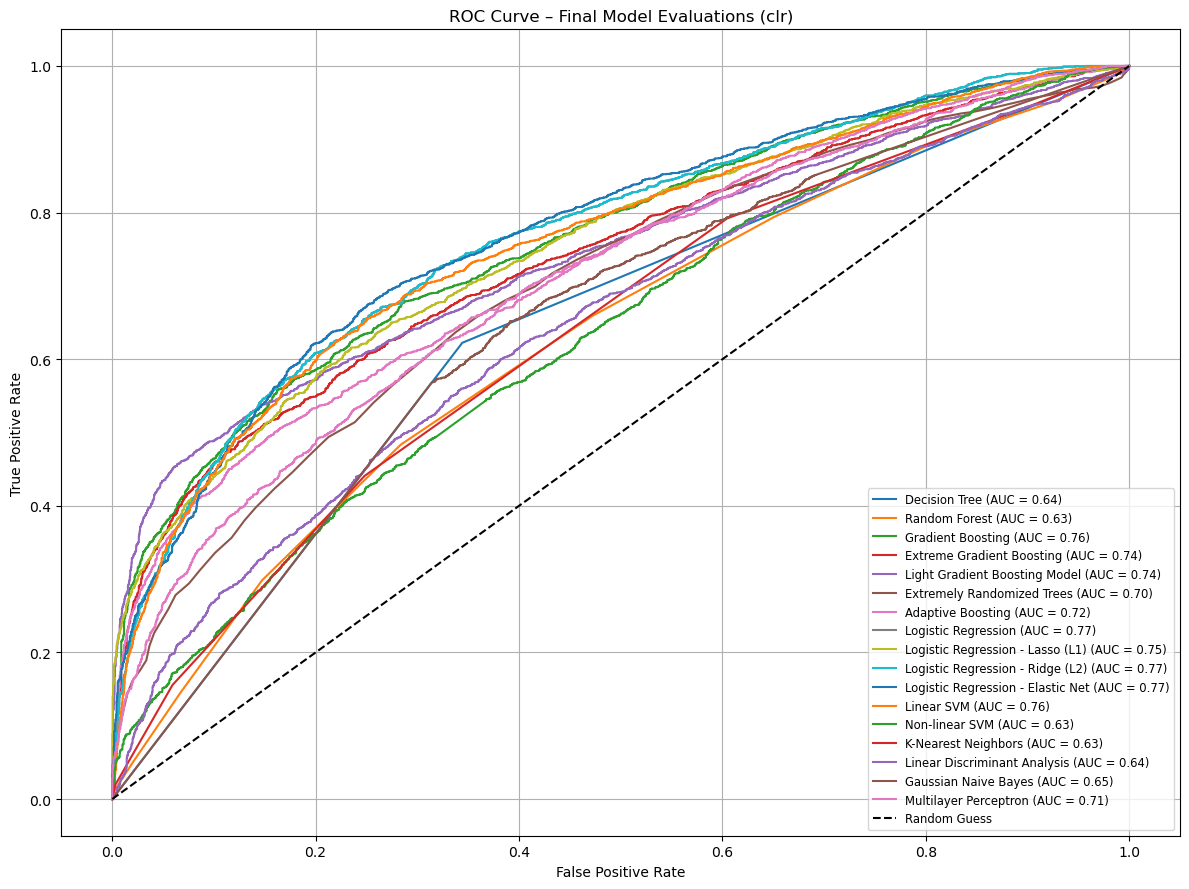

  Saved ROC curve to: ./results/visuals/training/roc_all_models_clr.png

Dataset: rarefied
  Processing models:


    Generating ROC: 100%|██████████████████████| 17/17 [00:00<00:00, 233.29it/s]


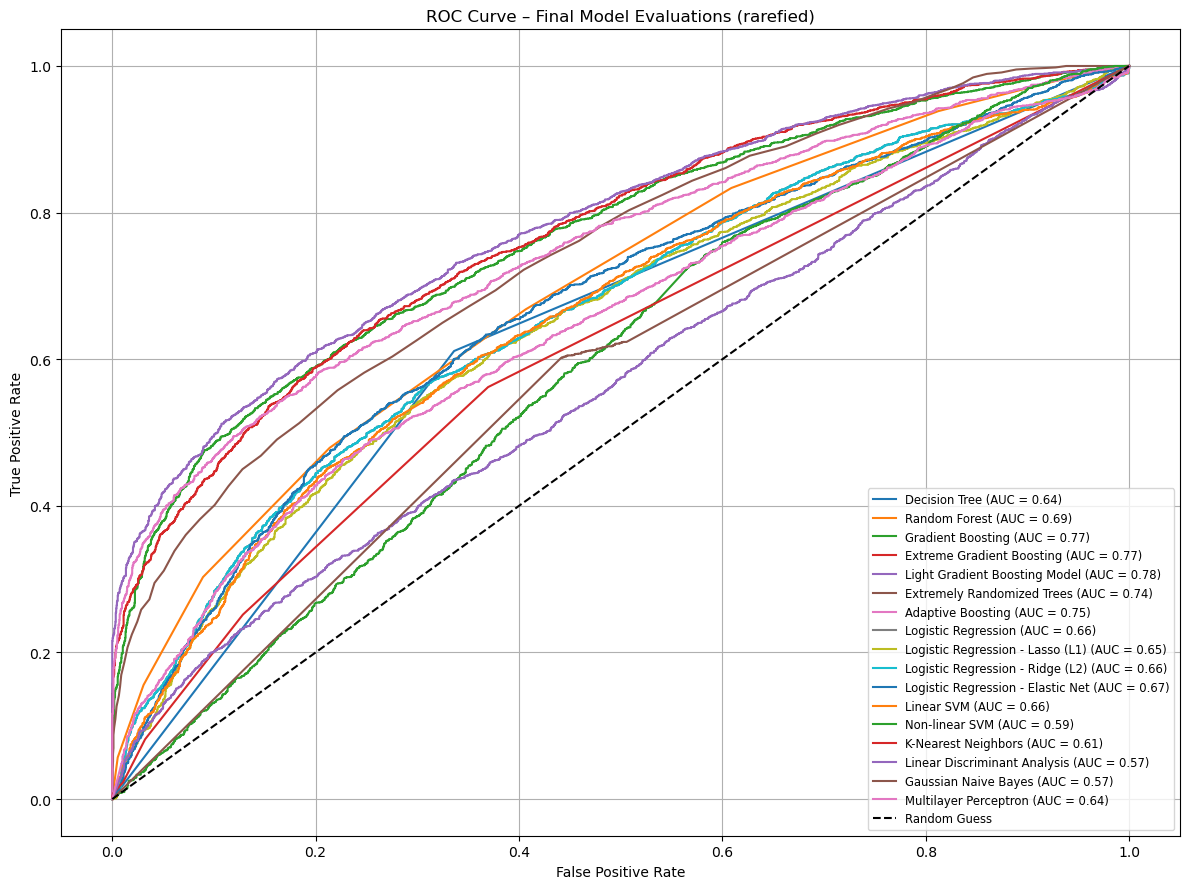

  Saved ROC curve to: ./results/visuals/training/roc_all_models_rarefied.png


In [3]:
def plot_training_roc_curves(dataset_names, results_dir="./results"):
    print("\nGenerating model comparison ROC curves using saved training predictions...")

    vis_dir = os.path.join(results_dir, "visuals", "training")
    pickle_dir = os.path.join(results_dir, "pickles")
    os.makedirs(vis_dir, exist_ok=True)

    for dataset_name in dataset_names:
        pickle_path = os.path.join(pickle_dir, f"training_output_{dataset_name}.pkl")
        print(f"\nDataset: {dataset_name}")

        if not os.path.exists(pickle_path):
            print(f"  Missing pickle: {pickle_path}")
            continue

        with open(pickle_path, "rb") as f:
            data = pickle.load(f)

        models = data.get("models", {})
        if not models:
            print("  No model data found in pickle.")
            continue

        plt.figure(figsize=(12, 9))
        print(f"  Processing models:")

        
        for model_name, model_data in tqdm(models.items(), desc="    Generating ROC", ncols=80):
            run_preds = model_data.get("run_predictions", [])
            y_true_all = []
            y_prob_all = []
            
            # collecting predictions from all runs
            for run in run_preds:
                y_true_all.extend(run["y_true"])
                y_prob_all.extend(run["y_prob"])

            if not y_true_all or not y_prob_all:
                print(f"    Skipping {model_name} due to missing predictions")
                continue

            # computing ROC & AUC
            fpr, tpr, _ = roc_curve(y_true_all, y_prob_all)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")


        plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve – Final Model Evaluations ({dataset_name})")
        plt.legend(loc="lower right", fontsize="small")
        plt.grid(True)
        plt.tight_layout()

        # saving the plot
        out_path = os.path.join(vis_dir, f"roc_all_models_{dataset_name}.png")
        plt.savefig(out_path)
        plt.show()
        plt.close()
        print(f"  Saved ROC curve to: {out_path}")


plot_training_roc_curves(dataset_names)
